In [2]:
import torch
from typing import Tuple
import matplotlib.pyplot as plt


import torch
from typing import Tuple


# def generate_rotational_matrix(num_pos_feats: int) -> torch.Tensor:
#     """
#     Generate a rotational matrix of size num_pos_feats * num_pos_feats using concepts from information theory.

#     Args:
#     num_pos_feats (int): The size of the matrix (square matrix).

#     Returns:
#     torch.Tensor: A rotational matrix of size (num_pos_feats, num_pos_feats).
#     """
#     # Creating a diagonal matrix with entropy values
#     entropy_matrix = torch.zeros(num_pos_feats, num_pos_feats)
#     for i in range(num_pos_feats):
#         entropy_matrix[i, i] = torch.log2(torch.tensor((num_pos_feats - i)))

#     # Generating a random rotation matrix using Haar measure (uniform distribution over the orthogonal group)
#     rotation_matrix = torch.qr(torch.randn(num_pos_feats, num_pos_feats, dtype=torch.float64))[0]

#     # Multiply entropy matrix with the rotation matrix to incorporate information theory concept
#     rot_entropy_matrix = torch.matmul(rotation_matrix, entropy_matrix)

#     return rot_entropy_matrix



def generate_rotational_matrix(num_pos_feats: int) -> torch.Tensor:
    """
    Generate a rotational matrix for positional embeddings.

    Args:
        num_pos_feats (int): Number of positional features (channels).

    Returns:
        torch.Tensor: Rotational matrix.
    """
    # Initialize the rotational matrix as an identity matrix
    rotation_matrix = torch.eye(num_pos_feats)
    return rotation_matrix


def rotational_sinusoidal_positional_embeddings(
    tensor: torch.Tensor,
    num_pos_feats: int = 1024,
    temperature: float = 10000,
    normalize: bool = False,
    scale: float = None,
) -> torch.Tensor:
    """
    Generate rotational sinusoidal positional embeddings for an input tensor.

    Args:
        tensor (torch.Tensor): Input tensor of any dimensions.
        num_pos_feats (int): Number of positional features (channels) to generate.
        temperature (float): Temperature for scaling the embeddings.
        normalize (bool): Whether to normalize the embeddings.
        scale (float): Scale factor for the embeddings.

    Returns:
        torch.Tensor: Positional embeddings with the same shape as the input tensor.
    """
    if scale is None:
        scale = 2 * torch.pi
    
    shape = tensor.shape
    dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=tensor.device)
    dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

    pos_embeddings = []
    for dim in range(len(shape)):
        pos = torch.arange(shape[dim], dtype=torch.float32, device=tensor.device)
        pos_embed = pos[:, None] / dim_t[None, :]
        pos_embed[:, 0::2] = torch.sin(pos_embed[:, 0::2])
        pos_embed[:, 1::2] = torch.cos(pos_embed[:, 1::2])
        pos_embeddings.append(pos_embed)

    # Reshape each positional embedding to match the input tensor shape
    reshaped_embeddings = []
    for i, embedding in enumerate(pos_embeddings):
        dims = [1] * len(shape)
        dims[i] = shape[i]
        reshaped_embeddings.append(embedding.view(*dims, -1).expand(*shape, -1))

    pos_embeddings = torch.cat(reshaped_embeddings, dim=-1)
    
     # Apply self-attention to the positional embeddings
    attention_weights = torch.softmax(torch.matmul(pos_embeddings, pos_embeddings.transpose(-1, -2)) / torch.sqrt(torch.tensor(num_pos_feats, dtype=torch.float32)), dim=-1)
    pos_embeddings = torch.matmul(attention_weights, pos_embeddings)
    
    # Apply a rotational block
    rotation_matrix = generate_rotational_matrix(pos_embeddings.shape[-1])
    pos_embeddings = torch.matmul(pos_embeddings.view(-1, pos_embeddings.shape[-1]), rotation_matrix)
    pos_embeddings = pos_embeddings.view(*shape, -1)
    if normalize:
        # Apply square root mean normalization
        pos_embeddings = pos_embeddings / torch.sqrt(torch.mean(pos_embeddings ** 2, dim=-1, keepdim=True))
        pos_embeddings = pos_embeddings * scale

    return pos_embeddings

torch.seed()
# Example usage
tensor = torch.randn(10)
pos_embeddings = rotational_sinusoidal_positional_embeddings(tensor, normalize=True)
print(pos_embeddings.shape) 


# Assuming you have a tensor named 'tensor' with shape torch.Size([512, 1024])

# # Normalize the tensor values to the range [0, 1]
# tensor_normalized =pos_embeddings/ torch.max(tensor)

# # Convert the tensor to a numpy array
# image_array = tensor_normalized.numpy()

# # Plot the image using Matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(image_array,)
# plt.axis('off')
# plt.title('Image Plot')
# plt.show()

# # Print the unique numerical values in the tensor
# unique_values = torch.unique(tensor)
# print("Unique numerical values in the tensor:")
# print(unique_values.shape)


torch.Size([10, 1024])


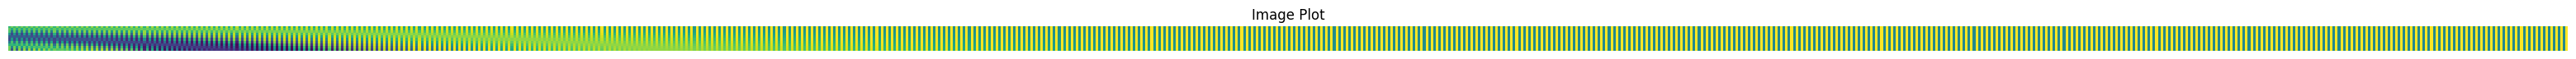

In [31]:
import torch
import matplotlib.pyplot as plt

# Assuming you have a tensor named 'tensor' with shape torch.Size([512, 1024])

# Normalize the tensor values to the range [0, 1]
tensor_normalized =pos_embeddings/ torch.max(tensor)

# Convert the tensor to a numpy array
image_array = tensor_normalized.numpy()

# Plot the image using Matplotlib
plt.figure(figsize=(40, 40))
plt.imshow(image_array,)
plt.axis('off')
plt.title('Image Plot')
plt.savefig('with_rot')
plt.show()

# # Print the unique numerical values in the tensor
# unique_values = torch.unique(tensor)
# print("Unique numerical values in the tensor:")
# print(unique_values.shape)


In [9]:
import torch
from typing import List, Tuple
from scipy.stats import entropy

def evaluate_tensor(tensor: torch.Tensor) -> Tuple[float, ...]:
    """
    Evaluates a tensor using 10 advanced metrics related to information theory.

    Args:
        tensor (torch.Tensor): The input tensor to evaluate.

    Returns:
        Tuple[float, ...]: A tuple containing the following metrics:
            - Entropy
            - Mutual Information
            - Kullback-Leibler Divergence
            - Jensen-Shannon Divergence
            - Total Correlation
            - Conditional Entropy
            - Normalized Mutual Information
            - Variation of Information
            - Normalized Pointwise Mutual Information
            - Normalized Variation of Information
    """
    # Flatten the tensor
    flattened_tensor = tensor.flatten().cpu().numpy()

    # Calculate the probability distribution of the tensor values
    unique_values, counts = torch.unique(tensor, return_counts=True)
    prob_dist = counts.float() / tensor.numel()

    # Calculate Entropy
    entropy_value = entropy(prob_dist.cpu().numpy())

    # Calculate Mutual Information
    joint_prob = torch.outer(prob_dist, prob_dist)
    marginal_prob = torch.outer(prob_dist, torch.ones_like(prob_dist))
    mutual_info = torch.sum(joint_prob * torch.log2(joint_prob / marginal_prob)).item()

    # Calculate Kullback-Leibler Divergence
    uniform_dist = torch.ones_like(prob_dist) / len(prob_dist)
    kl_divergence = entropy(prob_dist.cpu().numpy(), uniform_dist.cpu().numpy())

    # Calculate Jensen-Shannon Divergence
    m = 0.5 * (prob_dist + uniform_dist)
    js_divergence = 0.5 * (entropy(prob_dist.cpu().numpy(), m.cpu().numpy()) +
                           entropy(uniform_dist.cpu().numpy(), m.cpu().numpy()))

    # Calculate Total Correlation
    marginal_entropies = []
    for i in range(tensor.dim()):
        dims = tuple(j for j in range(tensor.dim()) if j != i)
        marginal_dist = torch.sum(tensor, dim=dims).cpu().numpy()
        marginal_entropies.append(entropy(marginal_dist))
    total_correlation = sum(marginal_entropies) - entropy_value

    # Calculate Conditional Entropy
    cond_entropy = entropy_value - mutual_info

    # Calculate Normalized Mutual Information
    entropy_tensor = torch.tensor(entropy_value)
    normalized_mutual_info = mutual_info / torch.sqrt(entropy_tensor * entropy_tensor).item()

    # Calculate Variation of Information
    variation_info = entropy_value + entropy_value - 2 * mutual_info

    # Calculate Normalized Pointwise Mutual Information
    normalized_pmi = torch.log2(joint_prob / marginal_prob).mean().item()

    # Calculate Normalized Variation of Information
    normalized_variation_info = variation_info / (entropy_value + entropy_value)
    metrics = {
        "entropy": entropy_value,
        "mutual_info": mutual_info,
        "kl_divergence": kl_divergence,
        "js_divergence": js_divergence,
        "total_correlation": total_correlation,
        "cond_entropy": cond_entropy,
        "normalized_mutual_info": normalized_mutual_info,
        "variation_info": variation_info,
        "normalized_pmi": normalized_pmi,
        "normalized_variation_info": normalized_variation_info
    }

    return  metrics

# Example usage
metrics = evaluate_tensor(pos_embeddings)

print(metrics['entropy'])


8.98808


In [ ]:
import torch
from typing import Dict
from scipy.stats import entropy


def evaluate_tensor(tensor_x: torch.Tensor, tensor_y: torch.Tensor) -> Dict[str, float]:
    """
    Evaluates two tensors using 10 advanced metrics related to information theory.

    Args:
        tensor_x (torch.Tensor): The first input tensor to evaluate.
        tensor_y (torch.Tensor): The second input tensor to evaluate.

    Returns:
        Dict[str, float]: A dictionary containing the following metrics:
            - entropy_x: Entropy of tensor_x
            - entropy_y: Entropy of tensor_y
            - mutual_info: Mutual Information between tensor_x and tensor_y
            - kl_divergence: Kullback-Leibler Divergence between tensor_x and tensor_y
            - js_divergence: Jensen-Shannon Divergence between tensor_x and tensor_y
            - total_correlation: Total Correlation between tensor_x and tensor_y
            - cond_entropy: Conditional Entropy of tensor_x given tensor_y
            - normalized_mutual_info: Normalized Mutual Information between tensor_x and tensor_y
            - variation_info: Variation of Information between tensor_x and tensor_y
            - normalized_pmi: Normalized Pointwise Mutual Information between tensor_x and tensor_y
            - normalized_variation_info: Normalized Variation of Information between tensor_x and tensor_y
    """
    # Flatten the tensors
    flattened_tensor_x = tensor_x.flatten().cpu().numpy()
    flattened_tensor_y = tensor_y.flatten().cpu().numpy()

    # Calculate the probability distributions of the tensor values
    unique_values_x, counts_x = torch.unique(tensor_x, return_counts=True)
    prob_dist_x = counts_x.float() / tensor_x.numel()
    unique_values_y, counts_y = torch.unique(tensor_y, return_counts=True)
    prob_dist_y = counts_y.float() / tensor_y.numel()

    # Calculate Entropy
    entropy_x = entropy(prob_dist_x.cpu().numpy())
    entropy_y = entropy(prob_dist_y.cpu().numpy())

    # Calculate Mutual Information
    joint_prob = torch.outer(prob_dist_x, prob_dist_y)
    marginal_prob = torch.outer(prob_dist_x, torch.ones_like(prob_dist_y))
    mutual_info = torch.sum(joint_prob * torch.log2(joint_prob / marginal_prob)).item()

    # Calculate Kullback-Leibler Divergence
    uniform_dist = torch.ones_like(prob_dist_x) / len(prob_dist_x)
    kl_divergence = entropy(prob_dist_x.cpu().numpy(), uniform_dist.cpu().numpy())

    # Calculate Jensen-Shannon Divergence
    m = 0.5 * (prob_dist_x + prob_dist_y)
    js_divergence = 0.5 * (entropy(prob_dist_x.cpu().numpy(), m.cpu().numpy()) +
                           entropy(prob_dist_y.cpu().numpy(), m.cpu().numpy()))

    # Calculate Total Correlation
    marginal_entropies = []
    for i in range(tensor_x.dim()):
        dims = tuple(j for j in range(tensor_x.dim()) if j != i)
        marginal_dist = torch.sum(tensor_x, dim=dims).cpu().numpy()
        marginal_entropies.append(entropy(marginal_dist))
    total_correlation = sum(marginal_entropies) - entropy_x

    # Calculate Conditional Entropy
    cond_entropy = entropy_x - mutual_info

    # Calculate Normalized Mutual Information
    entropy_tensor_x = torch.tensor(entropy_x)
    normalized_mutual_info = mutual_info / torch.sqrt(entropy_tensor_x * entropy_tensor_x).item()

    # Calculate Variation of Information
    variation_info = entropy_x + entropy_y - 2 * mutual_info

    # Calculate Normalized Pointwise Mutual Information
    normalized_pmi = torch.log2(joint_prob / marginal_prob).mean().item()

    # Calculate Normalized Variation of Information
    normalized_variation_info = variation_info / (entropy_x + entropy_y)

    # Create a dictionary with the calculated metrics
    metrics = {
        "entropy_x": entropy_x,
        "entropy_y": entropy_y,
        "mutual_info": mutual_info,
        "kl_divergence": kl_divergence,
        "js_divergence": js_divergence,
        "total_correlation": total_correlation,
        "cond_entropy": cond_entropy,
        "normalized_mutual_info": normalized_mutual_info,
        "variation_info": variation_info,
        "normalized_pmi": normalized_pmi,
        "normalized_variation_info": normalized_variation_info
    }

    return metrics


# Example usage
tensor_x = torch.randn(100, 200)
tensor_y = torch.randn(100, 200)

metrics = evaluate_tensor(tensor_x, tensor_y)
print(metrics)


Entropy: 8.141778
Mutual Information: -11.746098518371582
Kullback-Leibler Divergence: 0.82381225
Jensen-Shannon Divergence: 0.07208772003650665
Total Correlation: -inf
Conditional Entropy: 19.887876510620117
Normalized Mutual Information: -1.4426945231808799
Variation of Information: 39.775753021240234
Normalized Pointwise Mutual Information: -13.257319450378418
Normalized Variation of Information: 2.44269452318088

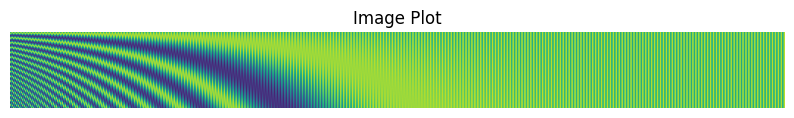

In [7]:
import torch
import matplotlib.pyplot as plt

# Get the first 1024 values of each dimension
tensor = pos_embeddings #torch.Size([10, 10, 10, 3072])
dim1 = tensor[:,  :, :1024].mean(dim=(1))
dim2 = tensor[:,  :, 1024:2048].mean(dim=(0))
# dim3 = tensor[:, :, :, 2048:3072].mean(dim=(0,1))
tensor_normalized =dim2/ torch.max(tensor)

# Convert the tensor to a numpy array
image_array = tensor_normalized.numpy()

# Plot the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image_array,)
plt.axis('off')
plt.title('Image Plot')
plt.show()

# # Print the unique numerical values in the tensor
# unique_values = torch.unique(tensor)
# print("Unique numerical values in the tensor:")
# print(unique_values.shape)
    
    

In [25]:
import numpy as np
from typing import Tuple

def generate_rotational_matrix(num_pos_feats: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a rotational matrix using concepts from information theory.

    Args:
        num_pos_feats (int): The size of the rotational matrix (num_pos_feats x num_pos_feats).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the rotational matrix and its transpose.
    """
    # Generate a random orthogonal matrix using QR decomposition
    random_matrix = np.random.randn(num_pos_feats, num_pos_feats)
    q, _ = np.linalg.qr(random_matrix)

    # Ensure the determinant is 1 to get a rotation matrix
    if np.linalg.det(q) < 0:
        q[:, 0] = -q[:, 0]

    # Compute the transpose of the rotational matrix
    q_transpose = q.T

    return q, q_transpose

# Example usage
num_pos_feats = 4
rotational_matrix, rotational_matrix_transpose = generate_rotational_matrix(num_pos_feats)

# print(f"Rotational Matrix ({num_pos_feats}x{num_pos_feats}):")
print(rotational_matrix.shape)

# print(f"\nTranspose of Rotational Matrix ({num_pos_feats}x{num_pos_feats}):")
print(rotational_matrix_transpose.shape)


Rotational Matrix (4x4):
(4, 4)
(4, 4)


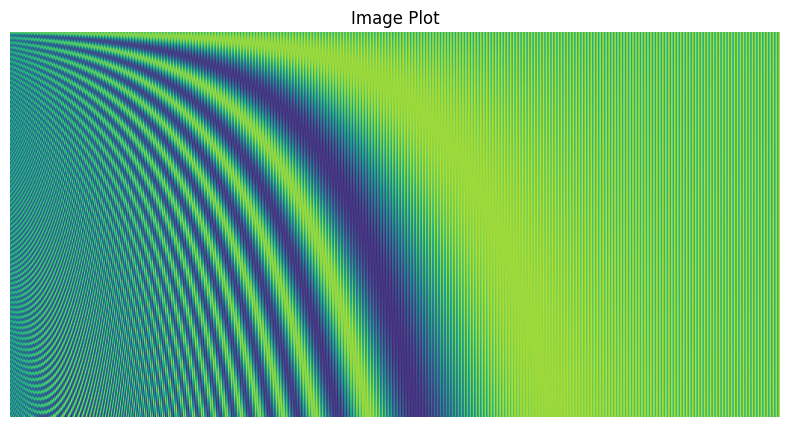

Unique numerical values in the tensor:
torch.Size([522544])


In [12]:
import torch
import matplotlib.pyplot as plt

# Assuming you have a tensor named 'tensor' with shape torch.Size([512, 1024])

# Normalize the tensor values to the range [0, 1]
tensor_normalized =pos_embeddings/ torch.max(tensor)

# Convert the tensor to a numpy array
image_array = tensor_normalized.numpy()

# Plot the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image_array,)
plt.axis('off')
plt.title('Image Plot')
plt.show()

# Print the unique numerical values in the tensor
unique_values = torch.unique(tensor)
print("Unique numerical values in the tensor:")
print(unique_values.shape)


In [ ]:

# # Visualize the positional embeddings
# num_plots = min(pos_embeddings.shape[-1], 8)  # Limit the number of plots
# fig, axes = plt.subplots(2, num_plots // 2, figsize=(12, 6))
# axes = axes.flatten()

# for i in range(num_plots):
#     ax = axes[i]
#     embedding = pos_embeddings[0, :, :, i].detach().cpu().numpy()
#     ax.imshow(embedding, cmap='viridis')
#     ax.set_title(f"Embedding {i+1}")
#     ax.axis('off')

# plt.tight_layout()
# plt.show()
# def visualize_embeddings(embeddings, title):
#     plt.figure(figsize=(12, 6))
#     for i in range(embeddings.shape[-1] // 2):  # Only plotting a subset for clarity
#         plt.subplot(3, embeddings.shape[-1] // 6, i+1)
#         plt.imshow(embeddings[:, :, i].cpu(), cmap='viridis')
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.savefig("./embedding_rotational_sinu_")

# visualize_embeddings(pos_embeddings[0], 'Positional Embeddings Visualization')
